In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
os.chdir("/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/privacy/")
from privacy.encode import encodeData, encodeNonAnonData
os.chdir("/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/")

In [13]:
data = "texas"
# degrees = [1, 2, 3]
degrees = [100]

In [14]:
class Synthetic_Utility:
    def __init__(self, data, degrees):
        self.data = data
        self.degrees = degrees
    
    def get_features(self):
        self.features = []
        self.val = []
        for degree in self.degrees:
            syn_path = f'/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/synthetic_results/{self.data}_syn_{degree}.csv'
            pr_anon, X_anon, y_anon = encodeNonAnonData(self.data, syn_path, is_syn=True)
            self.features.append((X_anon, y_anon))
        _, X_val, y_val = encodeNonAnonData(self.data, f'/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/data/{self.data}/val.csv')
        self.val_data = X_val, y_val

    def get_model(self):
        self.models = []
        for _ in range(len(self.features)):
            if self.data == "texas":
                model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(self.features[0][0].shape[1],)),
                    tf.keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
                    tf.keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
                    tf.keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
                    tf.keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
                    tf.keras.layers.Dense(1)])
            elif self.data == "adult":
                model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(self.features[0][0].shape[1],)),
                    tf.keras.layers.Dense(256, activation='relu'),
                    tf.keras.layers.Dropout(0.5),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dropout(0.5),
                    tf.keras.layers.Dense(64, activation='relu'),
                    tf.keras.layers.Dense(32, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')])
            else:
                model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(self.features[0][0].shape[1],)),
                    tf.keras.layers.Dense(10, activation='relu'),
                    tf.keras.layers.Dropout(0.5),
                    tf.keras.layers.Dense(4, activation='softmax')])
            self.models.append(model)

    def compile_models(self):
        for i in range(len(self.models)):
            if self.data == "adult":
                self.models[i].compile(optimizer='nadam',
                    loss='binary_crossentropy',
                    metrics=["accuracy"])
            elif self.data == "texas":
                self.models[i].compile(optimizer='nadam',
                    loss='mean_squared_error')
            else:
                self.models[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                    loss='categorical_crossentropy',
                    metrics=["accuracy"])

    def prepare_training(self):
        self.get_features()
        self.get_model()
        self.compile_models()
    
    def train(self):
        self.histories = []
        for i in range(len(self.degrees)):
            X, y = self.features[i]
            callback_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
            lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
            history = self.models[i].fit(X, y, batch_size=32, epochs=100, validation_data=self.val_data, callbacks=[callback_es, lr_scheduler])
            self.histories.append(history)
            self.models[i].save(f"./syn_weights/model_{self.data}_{self.degrees[i]}.h5")
            print(f"{i+1} trained.")
            

In [15]:
syn_util = Synthetic_Utility(data, degrees)

In [16]:
syn_util.prepare_training()

Replacing all generalized values...


75555it [00:02, 25915.95it/s]


Replacing all generalized values...


8396it [00:00, 26208.08it/s]


In [17]:
syn_util.train()

Epoch 1/100


2023-12-18 09:24:05.684462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2362/2362 [==============================] - ETA: 0s - loss: 0.7518

2023-12-18 09:24:57.177936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2362/2362 [==============================] - 53s 22ms/step - loss: 0.7518 - val_loss: 1.2579 - lr: 0.0010
Epoch 2/100
2362/2362 [==============================] - 53s 22ms/step - loss: 0.7096 - val_loss: 1.4156 - lr: 0.0010
Epoch 3/100
2362/2362 [==============================] - 52s 22ms/step - loss: 0.7011 - val_loss: 1.2271 - lr: 0.0010
Epoch 4/100
2362/2362 [==============================] - 54s 23ms/step - loss: 0.6950 - val_loss: 1.2189 - lr: 0.0010
Epoch 5/100
2362/2362 [==============================] - 54s 23ms/step - loss: 0.6905 - val_loss: 1.2368 - lr: 0.0010
Epoch 6/100
2362/2362 [==============================] - 54s 23ms/step - loss: 0.6886 - val_loss: 1.1874 - lr: 0.0010
Epoch 7/100
2362/2362 [==============================] - 53s 22ms/step - loss: 0.6850 - val_loss: 1.3534 - lr: 0.0010
Epoch 8/100
2362/2362 [==============================] - 54s 23ms/step - loss: 0.6834 - val_loss: 1.1976 - lr: 0.0010
Epoch 9/100
2362/2362 [==============================] - 55s 23ms/st

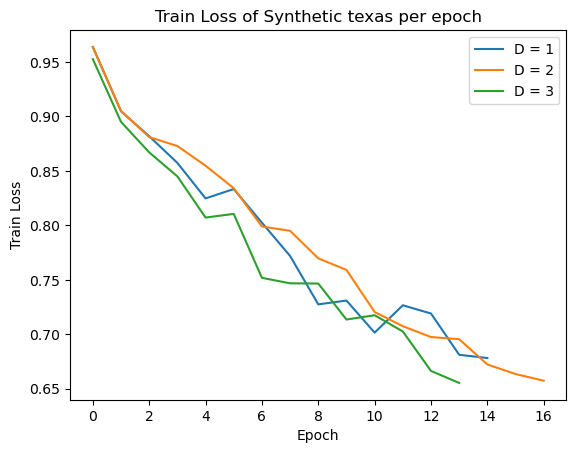

In [31]:
for i in range(len(syn_util.histories)):
    plt.plot(syn_util.histories[i].history['loss'], label=f"D = {syn_util.degrees[i]}")
plt.xlabel("Epoch")
plt.ylabel(f"Train Loss")
plt.title(f"Train Loss of Synthetic {data} per epoch")
plt.legend()
plt.show()

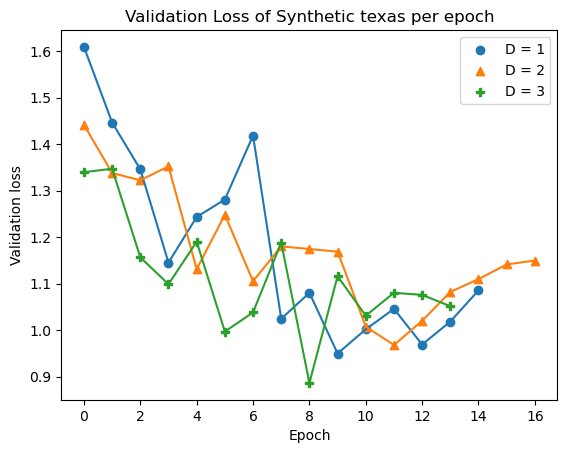

In [41]:
markers = ["o", "^", "P"]
for i in range(len(syn_util.histories)):
    plt.plot(syn_util.histories[i].history['val_loss'])
    plt.scatter(range(len(syn_util.histories[i].history['val_loss'])), 
                syn_util.histories[i].history['val_loss'],
                marker=markers[i],
                label=f"D = {syn_util.degrees[i]}")
plt.xlabel("Epoch")
plt.ylabel(f"Validation loss")
plt.title(f"Validation Loss of Synthetic {data} per epoch")
plt.legend()
plt.show()

In [18]:
_, X_test, y_test = encodeNonAnonData(data, f"/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/data/{data}/test.csv")
test_accs = {}
for i in range(len(syn_util.degrees)):
    syn_util.models[i] = tf.keras.models.load_model(f"./syn_weights/model_{data}_{syn_util.degrees[i]}.h5")
    X, y = syn_util.features[i]
    res = syn_util.models[i].evaluate(X_test, y_test, verbose=0)
    test_accs[f"D = {syn_util.degrees[i]}"] = res
test_accs["≈"] = 0.631491

Replacing all generalized values...


14815it [00:00, 25672.66it/s]
2023-12-18 09:34:13.567577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [20]:
test_accs["CTGAN"] = test_accs["D = 100"]
test_accs["Bayesian Networks (D1)"] = 0.862895

Text(0, 0.5, 'MSE Loss')

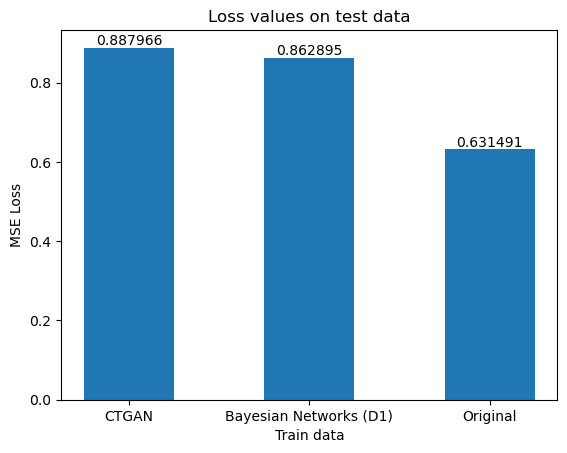

In [27]:
names = ["CTGAN", "Bayesian Networks (D1)", "Original"]
height = [test_accs[name] for name in names]
bar = plt.bar(names, height, width=0.5)
plt.bar_label(bar)
plt.title("Loss values on test data")
plt.xlabel("Train data")
plt.ylabel("MSE Loss")